In [1]:
import os

import datetime
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, ttest_rel, spearmanr, pearsonr
from scipy.fft import fft
import string

from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import gridspec
import matplotlib.lines as mlines
import seaborn as sns
import skill_metrics as sm
from sklearn.metrics import r2_score

import matplotlib.patches as mpatches

import plotly.graph_objs as go
from matplotlib.gridspec import GridSpec
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors  # For RGBA to hex conversion

from src.plots import *
from src.utilities import cal_metrics, mielke_lambda, percentile_mean, fluctuation_frequency

In [2]:
# Set inputs
TRANSECTS = ['Transect2', 'Transect5', 'Transect8'] # List of transects for evaluation


fp_input = 'datasets/shorelines' # File path for input data
fp_sub = 'submissions/{}' # File path for submission
fp_resub = 'resubmissions/{}' # File path for resubmission

fn_obs = 'shorelines_obs.csv' # File name for observed shoreline
fn_cali = 'shorelines_calibration.csv' # File name for calibration shoreline
fn_targ_short = 'shorelines_hidden_short.csv' # File name for target shoreline (short-term)
fn_targ_medium = 'shorelines_hidden_medium.csv' # File name for target shoreline (medium-term)
fn_pred_short = 'shorelines_prediction_short.csv' # File name for predicted shoreline (short-term)
fn_pred_medium = 'shorelines_prediction_medium.csv' # File name for predicted shoreline (medium-term)
fn_pred_RCP45 = 'shorelines_prediction_long_RCP45.csv' # File name for predicted shoreline (short-term)
fn_pred_RCP85 = 'shorelines_prediction_long_RCP85.csv' # File name for predicted shoreline (medium-term)

sep_time = datetime.datetime(year=1986, month=1, day=1) # Separate medium prediction to two periods

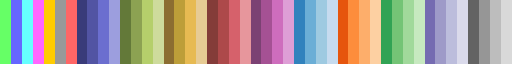

In [3]:
# n_colors = 10

# # Define the colormaps to sample from
# colormap_names = ['Purples', 'Blues', 'Greens', 'Oranges', 'Reds']

# # Create an array to store the colors
# colors = []

# # Sample colors from each colormap
# for cmap_name in colormap_names:
#     cmap = plt.get_cmap(cmap_name, n_colors)
#     colors.extend(cmap(np.linspace(0, 1, n_colors))[2:9])

# # Create a new colormap from the combined colors
# cmap = ListedColormap(colors)
# cmap

# Get the colors from tab20b and tab20c
tab20b = plt.get_cmap('tab20b')
tab20c = plt.get_cmap('tab20c')

# Combine the colors
colors_tab20b = tab20b(np.linspace(0, 1, 20))
colors_tab20c = tab20c(np.linspace(0, 1, 20))

# Concatenate the two sets of colors
combined_colors = np.vstack((np.array([[0.4, 1, 0.4, 1], [0.4, 0.4, 1, 1], [0.4, 1, 1, 1],
                                      [1, 0.4, 1, 1], [1, 0.8, 0, 1], [0.6, 0.6, 0.6, 1],
                                       [1, 0.4, 0.4, 1]]), 
                             colors_tab20b, colors_tab20c))

# Create a new colormap from the combined colors
cmap = plt.matplotlib.colors.ListedColormap(combined_colors)
cmap

In [4]:
# Read model metadata
df_meta = pd.read_excel('model_summary.xlsx', header=[1])
df_meta = df_meta[~df_meta['Model Name'].str.contains('corrected_JAAA')]
model_names = list(np.unique(df_meta['Model Name'].values))
MODEL_COLORS = dict(zip(model_names, cmap.colors[0:len(model_names)]))
MODEL_TYPES = dict(zip(df_meta['Model Name'], df_meta['Type']))
df_meta['Color'] = df_meta['Model Name'].apply(lambda x: MODEL_COLORS.get(x))

df_meta['Process'] = 'CS_LS'
df_meta.loc[(df_meta['Cross-Shore'].isna())&(~df_meta['Long-Shore'].isna()), 'Process']='LS_Only'
df_meta.loc[(~df_meta['Cross-Shore'].isna())&(df_meta['Long-Shore'].isna()), 'Process']='CS_Only'
#df_meta = df_meta[df_meta['Submission Type']=='Submission']

df_loss = pd.read_csv('figures/model_loss.csv', header=[0, 1], index_col=0).droplevel(0, axis=1)

#df_loss = df_loss.loc[df_loss.iloc[:, [0,1,2, 6, 7, 8]].mean(axis=1).sort_values().index]
df_loss['Avg'] = df_loss.iloc[:, [0,1,2, 6, 7, 8]].mean(axis=1)
df_loss['Resubmission'] = df_loss.index.str.contains("*", regex=False)
rank_index = df_loss.sort_values(['Avg']).index
df_loss = df_loss.sort_values(['Resubmission', 'Avg']).drop(columns=['Resubmission', 'Avg']).round(2)
#df_loss = df_loss[~df_loss.index.str.contains('*', regex=False)]

In [5]:
fn_targs = {'Short':fn_targ_short,
           'Medium (post-1986)':fn_targ_medium}
data_ranges = {
    'Short':pd.date_range(start='2019-01-01', end='2023-12-31'),
    'Medium (post-1986)':pd.date_range(start='1986-01-01', end='1999-02-16')
}

df_targ_all = {}
dfs_pred_all = {}


MODEL_TYPES = {}
MODEL_COLORS = {}
MODELS = []
for task in fn_targs.keys():
    print(task)
    fn_targ = fn_targs[task]
    fn_pred = fn_targ.replace('hidden', 'prediction')
    # Read obs and calibration shoreline data
    df_targ = pd.read_csv(os.path.join(fp_input, fn_targ), index_col='Datetime')
    df_targ.index = pd.to_datetime(df_targ.index)
    df_targ.sort_index(inplace=True)
    
    if task=='Medium (post-1986)':
        df_targ = df_targ.loc[df_targ.index>=sep_time]
    elif task=='Medium (pre-1986)':
        df_targ = df_targ.loc[df_targ.index<sep_time]
    else:
        df_targ = df_targ

    # Read model calibrations
    dfs_pred = {}
    freqs_pred = {} # This saves the frequency level of preds. High freq preds will be plotted on the bottom.
    for i, row in df_meta.iterrows():
        model = row['Model Name']
        if row['Submission Type'] == 'Submission':
            fp = fp_sub
        else:
            fp = fp_resub
        if os.path.exists(os.path.join(fp.format(model), fn_pred)):
            try:
                df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred), index_col='Datetime')
            except:
                df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred), index_col='datetime')
                df_pred.index.name = 'Datetime'
            df_pred.index = pd.to_datetime(df_pred.index)
            df_pred.sort_index(inplace=True)
            
            if fp == fp_resub:
                model = model + '$^*$'
            
            if not model in MODELS:
                MODELS.append(model)
                MODEL_TYPES[model] = row['Type']
                MODEL_COLORS[model] = row['Color']

            
            if task=='Medium (post-1986)':
                dfs_pred[model] = df_pred.loc[df_pred.index>=sep_time]
            elif task=='Medium (pre-1986)':
                dfs_pred[model] = df_pred.loc[df_pred.index<sep_time]
            else:
                dfs_pred[model] = df_pred
            if task=='Short':
                freqs_pred[model] = df_pred.apply(fluctuation_frequency).median()
            

    # Calculate ensembles
    ensemble_values = []
    index = data_ranges[task]

    for key, df_pred in dfs_pred.items():
        ensemble_values.append(df_pred[TRANSECTS].reindex(index).values) 
    ensemble_values = np.stack(ensemble_values)
    #ensemble_mean = np.mean(ensemble_values, axis=0)
    ensemble_mean = percentile_mean(ensemble_values, 5, 95, axis=0)
    ensemble_median = np.nanmedian(ensemble_values, axis=0)
    ensemble_max = np.nanmax(ensemble_values, axis=0)
    ensemble_min = np.nanmin(ensemble_values, axis=0)
    ensemble_std = np.nanstd(ensemble_values, axis=0)

    dfs_pred['Ensemble'] = pd.DataFrame(ensemble_mean, columns=TRANSECTS, index=index)
    if 'Ensemble' not in MODELS:
        MODELS.append('Ensemble')
    MODEL_TYPES['Ensemble'] = 'ENS'
    MODEL_COLORS['Ensemble'] = 'k'
    
    df_targ_all[task] = df_targ
    dfs_pred_all[task] = dfs_pred

Short
Medium (post-1986)


In [6]:
# df_targ_short = df_targ_all['Short'].sort_index()[TRANSECTS]
# dfs_item_short = dfs_pred_all['Short']
# dfs_item_short['Target'] = df_targ_short
# item_names = ['Target'] + list(df_loss.index)

# p_values = pd.DataFrame(np.ones((len(item_names), len(item_names))), columns=item_names, index=item_names)
# t_values = pd.DataFrame(np.ones((len(item_names), len(item_names))), columns=item_names, index=item_names)


# targ_index = df_targ_short.index
# for i, item_i in enumerate(item_names):
#     df_i = dfs_item_short[item_i]
#     for j in range(i):  # Only compute for lower triangle
#         item_j = item_names[j]
#         df_j = dfs_item_short[item_j]
        
        
#         index_intersect = df_i.index.intersection(df_j.index)
#         #index_intersect = df_i.index.intersection(df_j.index).intersection(targ_index)
#         array_i = df_i.loc[index_intersect, ['Transect2', 'Transect5', 'Transect8']].values.transpose().reshape(-1)
#         array_j = df_j.loc[index_intersect, ['Transect2', 'Transect5', 'Transect8']].values.transpose().reshape(-1)
        
#         nan_index = np.isnan(array_i)|np.isnan(array_j)
        
#         t_value, p_value = ttest_rel(array_i[~nan_index], array_j[~nan_index])
#         p_values.iloc[i, j] = p_value  # Fill lower triangle
#         t_values.iloc[i, j] = t_value  # Fill lower triangle

# # Mask the upper triangle for visualization
# mask = np.triu(np.ones_like(p_values, dtype=bool))
# cmap = plt.get_cmap("Reds")
# cmap_trunc = LinearSegmentedColormap.from_list('trunc_color', cmap(np.linspace(0.1, 0.8, 100)))
    

# # Create the heatmap
# plt.figure(figsize=(15, 12))
# sns.heatmap(
#     p_values.round(2),
#     mask=mask,
#     #annot=True,
#     fmt=".3f",
#     cmap=cmap_trunc,
#     cbar_kws={'label': r"P-value"},
#     annot_kws={"size": 8, "weight": "bold", "color": "black"},
#     linewidth=.5,
#     vmin=0,
#     vmax=0.1,
# #     norm=LogNorm(vmin=1e-100, vmax=0.1),
# )

# # Highlight p-values >= 0.05 with underscores in the annotations
# for i in range(1, len(p_values.columns)):
#     for j in range(i):
#         if p_values.iloc[i, j] > 0.05:  # Different trends threshold
#             plt.scatter(
#                 j + 0.5,
#                 i + 0.5,
#                 marker='*',
#                 color='white'

#             )

# #plt.title("Pairwise P-value Heatmap (Lower Triangle)")
# plt.xticks(rotation=90)
# plt.yticks(rotation=0)
# plt.tight_layout()
# plt.title("Paired T test")
# plt.show()

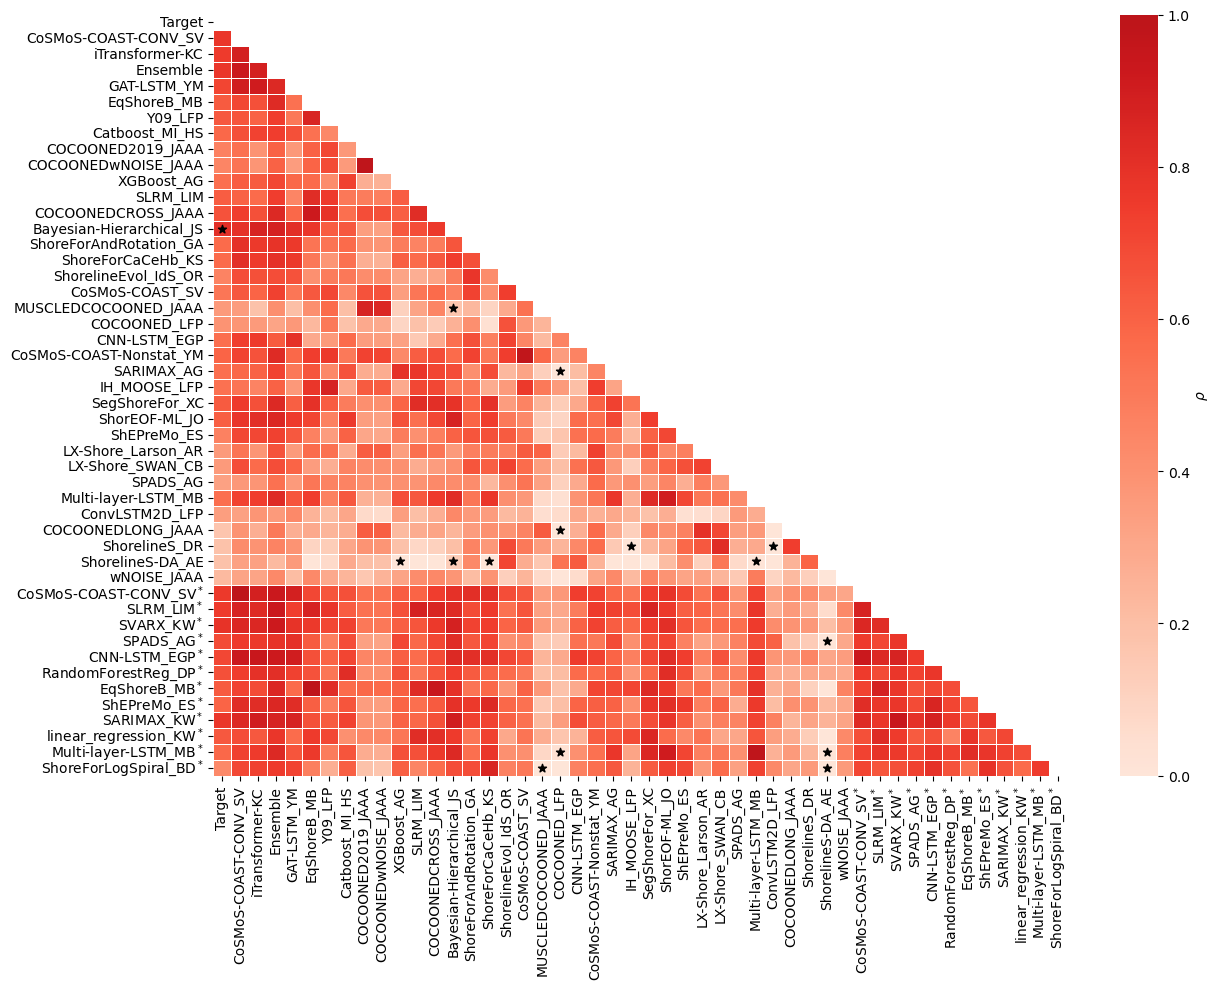

In [15]:
df_targ_short = df_targ_all['Short'].sort_index()[TRANSECTS]
dfs_item_short = dfs_pred_all['Short']
dfs_item_short['Target'] = df_targ_short
item_names = ['Target'] + list(df_loss.index)

p_values = pd.DataFrame(np.ones((len(item_names), len(item_names))), columns=item_names, index=item_names)
rhos = pd.DataFrame(np.ones((len(item_names), len(item_names))), columns=item_names, index=item_names)


targ_index = df_targ_short.index
for i, item_i in enumerate(item_names):
    df_i = dfs_item_short[item_i]
    for j in range(i):  # Only compute for lower triangle
        item_j = item_names[j]
        df_j = dfs_item_short[item_j]
        
        
        index_intersect = df_i.index.intersection(df_j.index)
        #index_intersect = df_i.index.intersection(df_j.index).intersection(targ_index)
        array_i = df_i.loc[index_intersect, ['Transect2', 'Transect5', 'Transect8']].values.transpose().reshape(-1)
        array_j = df_j.loc[index_intersect, ['Transect2', 'Transect5', 'Transect8']].values.transpose().reshape(-1)
        
        nan_index = np.isnan(array_i)|np.isnan(array_j)
        
        rho, p_value = pearsonr(array_i[~nan_index], array_j[~nan_index])
        p_values.iloc[i, j] = p_value  # Fill lower triangle
        rhos.iloc[i, j] = rho  # Fill lower triangle

# Mask the upper triangle for visualization
mask = np.triu(np.ones_like(p_values, dtype=bool))
cmap = plt.get_cmap("Reds")
cmap_trunc = LinearSegmentedColormap.from_list('trunc_color', cmap(np.linspace(0.1, 0.8, 100)))
    

# Create the heatmap
plt.figure(figsize=(13, 10))
sns.heatmap(
    rhos.round(2),
    mask=mask,
    #annot=True,
    fmt=".3f",
    cmap=cmap_trunc,
    cbar_kws={'label': r"$\rho$"},
    annot_kws={"size": 8, "weight": "bold", "color": "black"},
    linewidth=.5,
    vmin=0,
    vmax=1,
#     norm=LogNorm(vmin=1e-100, vmax=0.1),
)

# Highlight p-values >= 0.05 with underscores in the annotations
for i in range(1, len(p_values.columns)):
    for j in range(i):
        if p_values.iloc[i, j] > 0.01:  # Different trends threshold
            plt.scatter(
                j + 0.5,
                i + 0.5,
                marker='*',
                color='k'

            )
#         elif p_values.iloc[i, j] < 0.01: # Same trend
#             plt.scatter(
#                 j + 0.5,
#                 i + 0.5,
#                 marker='*',
#                 color='white'

#             )

#plt.title("Pairwise P-value Heatmap (Lower Triangle)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
#plt.title("Pearsonr's correlation test")
plt.savefig('figures/paper/FigS3.jpg', dpi=300, bbox_inches='tight')

In [8]:
i = 1
j = 2

item_i = item_names[i]
df_i = dfs_item_short[item_i]

item_j = item_names[j]
df_j = dfs_item_short[item_j]
        
index_intersect = df_i.index.intersection(df_j.index)
array_i = df_i.loc[index_intersect, ['Transect2', 'Transect8']].values.transpose().reshape(-1)
array_j = df_j.loc[index_intersect, ['Transect2', 'Transect8']].values.transpose().reshape(-1)
nan_index = np.isnan(array_i)|np.isnan(array_j)
rho, p_value = spearmanr(array_i[~nan_index], array_j[~nan_index])

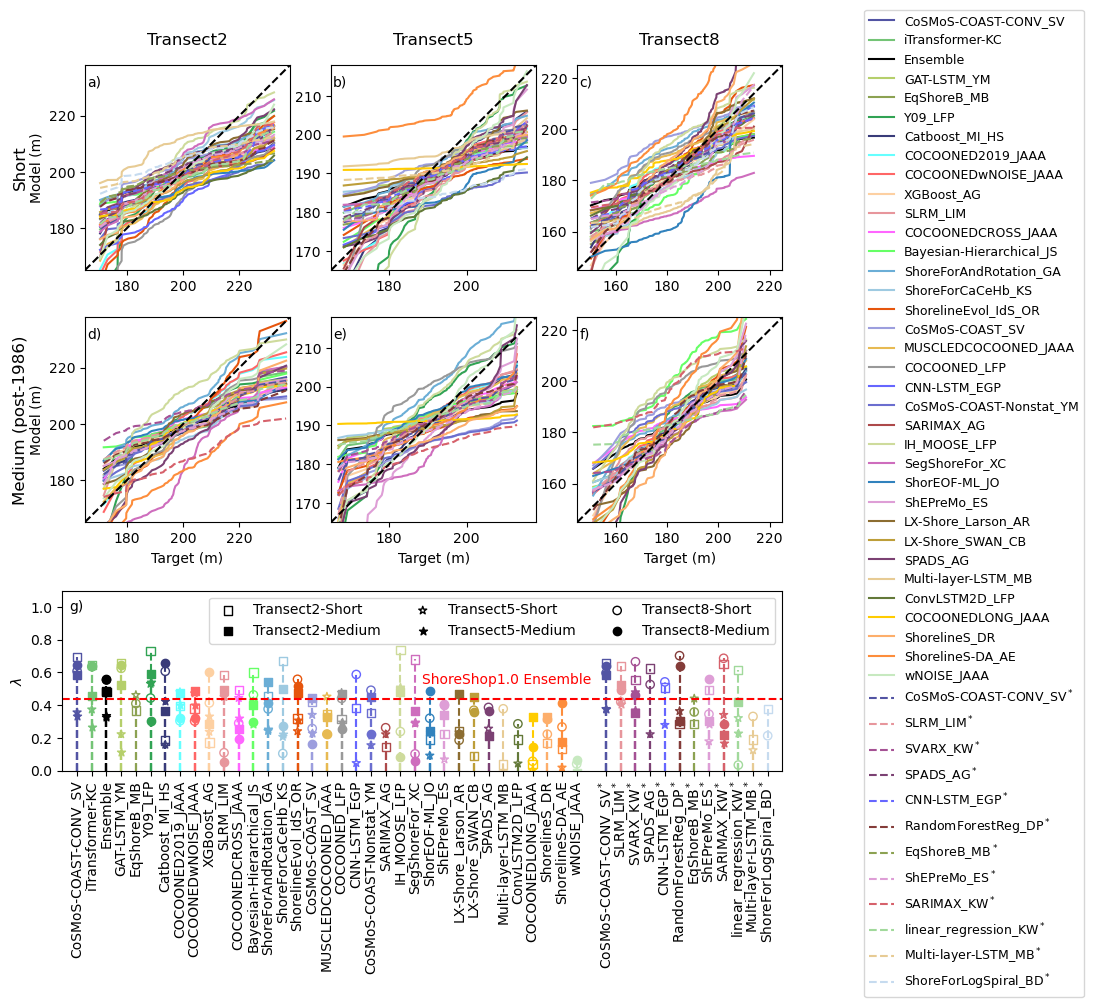

In [9]:
quantiles = np.linspace(0, 1, 100) 
lims = {
    'Transect2':[165, 238],
    'Transect5':[165, 218],
    'Transect8':[145, 225],
    
}

markers = {
    'Transect2':'s',
    'Transect5':'*',
    'Transect8':'o', 
}


fig, axes = plt.subplots(2, 3, figsize=(9, 6))
ax2 = fig.add_axes([0.1, -0.3, 0.8, 0.3])
letters = string.ascii_lowercase # Letters used to label subplots

count = 0
for i, task in enumerate(['Short', 'Medium (post-1986)']):
    for j, tran_id in enumerate(TRANSECTS):
        ax = axes[i, j]
        ax.text(0.01,0.95, letters[count] + ')', ha='left',va='top', transform=ax.transAxes, zorder=10)
        count += 1
        

        for k, model_name in enumerate(df_loss.index):
            targ = df_targ_all[task][tran_id]
            if model_name in dfs_pred_all[task].keys():
            
                model = dfs_pred_all[task][model_name][tran_id]

                targ_quantiles = np.nanquantile(targ, quantiles)
                model_quantiles = np.nanquantile(model, quantiles)
                
                if '*' in model_name:
                    line_style = '--'
                    k = k+1
                else:
                    line_style = '-'

                ax.plot(targ_quantiles, model_quantiles, label=model_name, color=MODEL_COLORS[model_name],
                       linestyle = line_style)
                
                
                mielke = mielke_lambda(targ.dropna(), model.reindex(targ.dropna().index, method='nearest'))
                r2 = r2_score(targ.dropna(), model.reindex(targ.dropna().index, method='nearest'))
                if task == 'Short':
                    facecolor = 'None'
                else:
                    facecolor = MODEL_COLORS[model_name]
                
                
                ax2.scatter(k, mielke, color=MODEL_COLORS[model_name], marker=markers[tran_id], facecolor=facecolor)
                ax2.plot([k, k], [0, mielke], color=MODEL_COLORS[model_name], linestyle='--')

                
#                 ax3.scatter(k, r2, color=MODEL_COLORS[model_name], marker=markers[tran_id], facecolor=facecolor)
#                 ax3.axvline(k, ymin=0, ymax=r2, color=MODEL_COLORS[model_name], linestyle='--')


                
                
                
        ax.plot(lims[tran_id], lims[tran_id], 'k--')
        ax.set_aspect('equal')
#         ax.set_xlim(min(targ_quantiles)-5, max(targ_quantiles)+5)
#         ax.set_ylim(min(targ_quantiles)-5, max(targ_quantiles)+5)
        ax.set_xlim(lims[tran_id])
        ax.set_ylim(lims[tran_id])
        
        
        if j !=0:
            ax.set_ylabel('')
            #ax.set_yticklabels([])
        else:
            ax.set_ylabel('Model (m)')
        if j == 0:
            ax.text(-0.35, 0.5, '{}'.format(task), rotation=90, transform=ax.transAxes,
                    fontsize=12, verticalalignment='center')
        if i!=1:
            ax.set_xlabel('')
            #ax.set_xticklabels([])
        else:
            ax.set_xlabel('Target (m)')
        if i == 0:          
            ax.text(0.5, 1.1, '{}'.format(tran_id), transform=ax.transAxes, 
                    fontsize=12, horizontalalignment='center')
        
        if task == 'Short':
            facecolor = 'None'
        else:
            facecolor = 'k'
            
        if task == 'Medium (post-1986)':
            label = '{}-Medium'.format(tran_id)
        else:
            label = '{}-Short'.format(tran_id)
        
        ax2.scatter([], [], marker=markers[tran_id], color='k', facecolor=facecolor,
                    label=label)
        

    if i == 0:
        ax.legend(bbox_to_anchor=[2.5, 1.3], loc=1, ncol=1, fontsize=9)

        
ax2.axhline(0.44, color='r', linestyle='--')
ax2.text(35, 0.6, 'ShoreShop1.0 Ensemble', ha='right',va='top', color='r')
ax2.text(0.01,0.95, letters[6] + ')', ha='left',va='top', transform=ax2.transAxes, zorder=10)
ax2.set_xlim(-1, len(df_meta)+2)
ax2.set_ylim(0, 1.1)
ax2.set_ylabel(r'$\lambda$')
ax2.set_xticks(list(range(35)) + list(range(36, len(df_loss)+1)))
ax2.set_xticklabels([])
ax2.set_xticklabels(df_loss.index, rotation=90)
ax2.set_yticks(np.arange(0, 1.2, 0.2))

handles, labels = ax2.get_legend_handles_labels()
ncol = 3
reordered_handles = [handles[i + j * ncol] for i in range(ncol) for j in range(len(handles) // ncol)]
reordered_labels = [labels[i + j * ncol] for i in range(ncol) for j in range(len(labels) // ncol)]

ax2.legend(reordered_handles, reordered_labels, ncol=ncol)
#plt.savefig('figures/paper/Fig6.jpg', dpi=300, bbox_inches='tight')

# ax3.axhline(0.39, color='r', linestyle='--')
# ax3.text(39, 0.5, 'ShoreShop1.0 Ensemble', ha='right',va='top', color='r')
# ax3.text(0.01,0.95, letters[7] + ')', ha='left',va='top', transform=ax3.transAxes, zorder=10)
# ax3.set_ylim(0, 0.9)
# ax3.set_ylabel(r'$R^2$')
# ax3.set_xticks(range(len(df_loss)))
# ax3.set_xticklabels(df_loss.index, rotation=90)
# ax3.legend(loc=1, ncol=2)
plt.savefig('figures/paper/Fig6.jpg', dpi=300, bbox_inches='tight')

In [10]:
# quantiles = np.linspace(0, 1, 100) 
# lims = {
#     'Transect2':[165, 238],
#     'Transect5':[165, 218],
#     'Transect8':[145, 225],
    
# }

# markers = {
#     'Transect2':'s',
#     'Transect5':'*',
#     'Transect8':'o', 
# }


# fig, axes = plt.subplots(2, 3, figsize=(9, 6))
# ax2 = fig.add_axes([0.1, -0.3, 0.8, 0.3])
# ax3 = fig.add_axes([0.1, -0.62, 0.8, 0.3])
# letters = string.ascii_lowercase # Letters used to label subplots

# count = 0
# for i, task in enumerate(['Short', 'Medium (post-1986)']):
#     for j, tran_id in enumerate(TRANSECTS):
#         ax = axes[i, j]
#         ax.text(0.01,0.95, letters[count] + ')', ha='left',va='top', transform=ax.transAxes, zorder=10)
#         count += 1
        
#         for k, model_name in enumerate(df_loss.index):
#             targ = df_targ_all[task][tran_id]
#             if model_name in dfs_pred_all[task].keys():
            
#                 model = dfs_pred_all[task][model_name][tran_id]

#                 targ_quantiles = np.nanquantile(targ, quantiles)
#                 model_quantiles = np.nanquantile(model, quantiles)

#                 ax.plot(targ_quantiles, model_quantiles, label=model_name, color=MODEL_COLORS[model_name])
                
                
#                 mielke = mielke_lambda(targ.dropna(), model.reindex(targ.dropna().index, method='nearest'))
#                 r2 = r2_score(targ.dropna(), model.reindex(targ.dropna().index, method='nearest'))
#                 if task == 'Short':
#                     facecolor = 'None'
#                 else:
#                     facecolor = MODEL_COLORS[model_name]
                
#                 ax2.scatter(k, mielke, color=MODEL_COLORS[model_name], marker=markers[tran_id], facecolor=facecolor)
#                 ax2.axvline(k, ymin=0, ymax=mielke, color=MODEL_COLORS[model_name], linestyle='--')
#                 ax3.scatter(k, r2, color=MODEL_COLORS[model_name], marker=markers[tran_id], facecolor=facecolor)
#                 ax3.axvline(k, ymin=0, ymax=r2, color=MODEL_COLORS[model_name], linestyle='--')
                
                
                
#         ax.plot(lims[tran_id], lims[tran_id], 'k--')
#         ax.set_aspect('equal')
# #         ax.set_xlim(min(targ_quantiles)-5, max(targ_quantiles)+5)
# #         ax.set_ylim(min(targ_quantiles)-5, max(targ_quantiles)+5)
#         ax.set_xlim(lims[tran_id])
#         ax.set_ylim(lims[tran_id])
        
        
#         if j !=0:
#             ax.set_ylabel('')
#             ax.set_yticklabels([])
#         else:
#             ax.set_ylabel('Model (m)')
#         if j == 0:
#             ax.text(-0.35, 0.5, '{}'.format(task), rotation=90, transform=ax.transAxes,
#                     fontsize=12, verticalalignment='center')
#         if i!=1:
#             ax.set_xlabel('')
#             ax.set_xticklabels([])
#         else:
#             ax.set_xlabel('Target (m)')
#         if i == 0:          
#             ax.text(0.5, 1.1, '{}'.format(tran_id), transform=ax.transAxes, 
#                     fontsize=12, horizontalalignment='center')
        
#         if task == 'Short':
#             facecolor = 'None'
#         else:
#             facecolor = 'k'
#         ax3.scatter([], [], marker=markers[tran_id], color='k', facecolor=facecolor,
#                     label='{}-{}'.format(tran_id, task))

#     if i == 0:
#         ax.legend(bbox_to_anchor=[2.5, 1], loc=1, ncol=1, fontsize=9)

        
# ax2.axhline(0.44, color='r', linestyle='--')
# ax2.text(39, 0.6, 'ShoreShop1.0 Ensemble', ha='right',va='top', color='r')
# ax2.text(0.01,0.95, letters[6] + ')', ha='left',va='top', transform=ax2.transAxes, zorder=10)
# ax2.set_ylim(0, 0.9)
# ax2.set_ylabel(r'$\lambda$')
# ax2.set_xticks(range(len(df_loss)))
# ax2.set_xticklabels([])

# ax3.axhline(0.39, color='r', linestyle='--')
# ax3.text(39, 0.5, 'ShoreShop1.0 Ensemble', ha='right',va='top', color='r')
# ax3.text(0.01,0.95, letters[7] + ')', ha='left',va='top', transform=ax3.transAxes, zorder=10)
# ax3.set_ylim(0, 0.9)
# ax3.set_ylabel(r'$R^2$')
# ax3.set_xticks(range(len(df_loss)))
# ax3.set_xticklabels(df_loss.index, rotation=90)
# ax3.legend(loc=1, ncol=2)
# plt.savefig('figures/paper/Fig6.jpg', dpi=300, bbox_inches='tight')